# Exploração, Ingestão e Limpeza — Dataset **Distribuição de Renda**

**Objetivo desta etapa:** preparar um subconjunto com **3 variáveis contínuas** para o projeto de **K-Means 3D**.

**Variáveis-alvo (nome lógico):**
1. `rtb_centil` — *Rendimentos Tributáveis (soma da RTB do centil)*
2. `imoveis` — *Bens e Direitos – Imóveis*
3. `dividas_onus` — *Dívidas e Ônus*

**Entregáveis (DoD):**
- Arquivo processado em `data/processed/distribuicao-renda-3vars.csv`
- Decisões documentadas (nulos, tipos, outliers)
- Código reprodutível


In [2]:
# Pacotes base
import os, sys, json, csv, io, textwrap
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Exibição
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Paths do projeto
ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

RAW_FILE = DATA_RAW / "distribuicao-renda.csv"  # ⚠️ ajuste se o nome for outro

print("ROOT:", ROOT)
print("RAW_FILE:", RAW_FILE.exists(), RAW_FILE)
print("OUTPUT DIR:", DATA_PROCESSED)


ROOT: C:\QuartoSemestre\kmeans-3d-cluster
RAW_FILE: True C:\QuartoSemestre\kmeans-3d-cluster\data\raw\distribuicao-renda.csv
OUTPUT DIR: C:\QuartoSemestre\kmeans-3d-cluster\data\processed


## Leitura do CSV (detecção de separador e encoding)

- Detectar *delimiter* automaticamente (`,` `;` `\t`)
- Tentar encodings comuns: `utf-8`, `latin-1`, `utf-8-sig`


In [3]:
def detect_delimiter(sample_bytes: bytes, default=","):
    try:
        dialect = csv.Sniffer().sniff(sample_bytes.decode(errors="ignore"), delimiters=[",",";","\t","|"])
        return dialect.delimiter
    except Exception:
        return default

def try_read_csv(path: Path, encodings=("utf-8", "latin-1", "utf-8-sig")):
    # pega um pequeno sample para o sniffer
    with open(path, "rb") as f:
        sample = f.read(4096)
    delim = detect_delimiter(sample)

    last_err = None
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc, sep=delim)
            return df, enc, delim
        except Exception as e:
            last_err = e
    raise last_err

df_raw, used_encoding, used_sep = try_read_csv(RAW_FILE)
print(f"Encoding detectado: {used_encoding} | Delimiter: {repr(used_sep)}")
df_raw.head()


Encoding detectado: utf-8 | Delimiter: ';'


,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões],Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões],Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões],Rendimentos Tributaveis - Média da RTB do Centil [R$],Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões],Rendimentos Isentos - Lucros e dividendos [R$ milhões],Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões],Rendimentos Isentos - Outros Rendimentos Isentos [R$ milhões],Despesas Dedutíveis - Previdência [R$ milhões],Despesas Dedutíveis - Dependentes [R$ milhões],Despesas Dedutíveis - Instrução [R$ milhões],Despesas Dedutíveis - Médicas [R$ milhões],Despesas Dedutíveis - Pensão Alimentícia [R$ milhões],Despesas Dedutíveis - Livro-Caixa [R$ milhões],Imposto Devido [R$ milhões],Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Móveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Bens e Direitos - Outros Bens e Direitos [R$ milhões],Dívidas e Ônus [R$ milhões]
0,2006,BRASIL,1,241.563,NaN,NaN,NaN,NaN,"235,61","481,27","27,37","1.694,49",NaN,NaN,NaN,NaN,NaN,NaN,"0,16","5.281,59","686,21","6.549,15","1.006,40","1.610,39"
1,2006,BRASIL,2,241.563,NaN,NaN,NaN,NaN,"208,74","483,44","29,36","1.675,01",NaN,NaN,NaN,NaN,NaN,NaN,"0,22","5.295,48","668,82","5.762,77","681,75","694,12"
2,2006,BRASIL,3,241.562,NaN,NaN,NaN,NaN,"219,96","459,87","27,63","1.683,04",NaN,NaN,NaN,NaN,NaN,NaN,"0,31","5.566,27","670,64","5.451,95","377,17","650,98"
3,2006,BRASIL,4,241.563,NaN,NaN,NaN,NaN,"257,01","481,93","31,77","1.699,89",NaN,NaN,NaN,NaN,NaN,NaN,"0,17","5.860,02","678,44","6.104,09","256,16","1.079,20"
4,2006,BRASIL,5,241.562,NaN,NaN,NaN,NaN,"249,88","464,23","28,11","1.697,17",NaN,NaN,NaN,NaN,NaN,NaN,"0,17","5.193,31","682,38","5.592,52","269,28","671,97"


## Inspeção inicial

- Dimensão, nomes de colunas
- *Preview* das primeiras linhas


In [4]:
print("Shape:", df_raw.shape)
print("\nColunas:")
print(list(df_raw.columns))

display(df_raw.head(10))


Shape: (46350, 24)

Colunas:
['Ano-calendário', 'Ente Federativo', 'Centil', 'Quantidade de Contribuintes', 'Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões]', 'Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões]', 'Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões]', 'Rendimentos Tributaveis - Média da RTB do Centil [R$]', 'Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões]', 'Rendimentos Isentos - Lucros e dividendos [R$ milhões]', 'Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões]', 'Rendimentos Isentos - Outros Rendimentos Isentos [R$ milhões]', 'Despesas Dedutíveis - Previdência [R$ milhões]', 'Despesas Dedutíveis - Dependentes [R$ milhões]', 'Despesas Dedutíveis - Instrução [R$ milhões]', 'Despesas Dedutíveis - Médicas [R$ milhões]', 'Despesas Dedutíveis - Pensão Alimentícia [R$ milhões]', 'Despesas Dedutíveis - Livro-Caixa [R$ milhões]', 'Imposto Devido [R$ milhões]', 'Bens e Direitos - Imóveis [R$ milhões]

,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões],Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões],Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões],Rendimentos Tributaveis - Média da RTB do Centil [R$],Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões],Rendimentos Isentos - Lucros e dividendos [R$ milhões],Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões],Rendimentos Isentos - Outros Rendimentos Isentos [R$ milhões],Despesas Dedutíveis - Previdência [R$ milhões],Despesas Dedutíveis - Dependentes [R$ milhões],Despesas Dedutíveis - Instrução [R$ milhões],Despesas Dedutíveis - Médicas [R$ milhões],Despesas Dedutíveis - Pensão Alimentícia [R$ milhões],Despesas Dedutíveis - Livro-Caixa [R$ milhões],Imposto Devido [R$ milhões],Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Móveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Bens e Direitos - Outros Bens e Direitos [R$ milhões],Dívidas e Ônus [R$ milhões]
0,2006,BRASIL,1,241.563,NaN,NaN,NaN,NaN,"235,61","481,27","27,37","1.694,49",NaN,NaN,NaN,NaN,NaN,NaN,"0,16","5.281,59","686,21","6.549,15","1.006,40","1.610,39"
1,2006,BRASIL,2,241.563,NaN,NaN,NaN,NaN,"208,74","483,44","29,36","1.675,01",NaN,NaN,NaN,NaN,NaN,NaN,"0,22","5.295,48","668,82","5.762,77","681,75","694,12"
2,2006,BRASIL,3,241.562,NaN,NaN,NaN,NaN,"219,96","459,87","27,63","1.683,04",NaN,NaN,NaN,NaN,NaN,NaN,"0,31","5.566,27","670,64","5.451,95","377,17","650,98"
3,2006,BRASIL,4,241.563,NaN,NaN,NaN,NaN,"257,01","481,93","31,77","1.699,89",NaN,NaN,NaN,NaN,NaN,NaN,"0,17","5.860,02","678,44","6.104,09","256,16","1.079,20"
4,2006,BRASIL,5,241.562,NaN,NaN,NaN,NaN,"249,88","464,23","28,11","1.697,17",NaN,NaN,NaN,NaN,NaN,NaN,"0,17","5.193,31","682,38","5.592,52","269,28","671,97"
5,2006,BRASIL,6,241.563,NaN,NaN,NaN,NaN,"225,07","454,74","24,73","1.604,68",NaN,NaN,NaN,NaN,NaN,NaN,"0,13","5.193,68","662,55","6.611,62","265,35","612,02"
6,2006,BRASIL,7,241.562,NaN,NaN,NaN,NaN,"240,87","460,86","27,69","1.608,30",NaN,NaN,NaN,NaN,NaN,NaN,"0,08","5.316,54","701,6","5.652,74","389,85","863,93"
7,2006,BRASIL,8,241.563,NaN,NaN,NaN,NaN,"244,43","569,25","29,76","1.751,91",NaN,NaN,NaN,NaN,NaN,NaN,"0,1","5.443,09","673,85","6.197,00","336,04","629,92"
8,2006,BRASIL,9,241.562,NaN,NaN,NaN,NaN,"176,14","536,98","24,94","1.581,53",NaN,NaN,NaN,NaN,NaN,NaN,"0,21","5.274,17","658,96","5.903,26","232,22","933,64"
9,2006,BRASIL,10,241.563,NaN,NaN,NaN,NaN,"259,26","547,41","30,08","1.756,96",NaN,NaN,NaN,NaN,NaN,NaN,"0,16","5.219,60","687,21","5.627,35","281,04","685,59"


## Seleção das 3 variáveis

Mapeamento **flexível** por padrões de nome para localizar as colunas no CSV, mesmo que o nome não seja idêntico.


In [5]:
import re

# ⚠️ Ajuste os padrões abaixo para refletir melhor os nomes reais do seu CSV.
PATTERNS = {
    "rtb_centil":  r"(rtb|rendimentos?\s*tribut[aá]veis?).*(centil|soma)|soma.*rtb",
    "imoveis":     r"(bens?.*direitos?.*im[oó]veis?|im[oó]veis)",
    "dividas_onus":r"(d[ií]vidas?).*(onus|ônus)|onus|ônus"
}

def find_column(pattern, columns):
    # case-insensitive, ignora acentos básicos
    regex = re.compile(pattern, flags=re.IGNORECASE)
    for c in columns:
        if regex.search(str(c)):
            return c
    return None

selected_cols = {}
for key, pattern in PATTERNS.items():
    col = find_column(pattern, df_raw.columns)
    selected_cols[key] = col

selected_cols


{'rtb_centil': 'Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões]',
 'imoveis': 'Bens e Direitos - Imóveis [R$ milhões]',
 'dividas_onus': 'Dívidas e Ônus [R$ milhões]'}

In [6]:
if any(v is None for v in selected_cols.values()):
    raise ValueError(
        "Nem todas as variáveis foram encontradas. Resultado do mapeamento:\n"
        + json.dumps(selected_cols, indent=2, ensure_ascii=False)
        + "\n→ Ajuste os padrões da célula anterior (PATTERNS)."
    )

df = df_raw[[selected_cols["rtb_centil"], selected_cols["imoveis"], selected_cols["dividas_onus"]]].copy()
df.columns = ["rtb_centil", "imoveis", "dividas_onus"]  # padroniza nomes
df.head()


,rtb_centil,imoveis,dividas_onus
0,NaN,"5.281,59","1.610,39"
1,NaN,"5.295,48","694,12"
2,NaN,"5.566,27","650,98"
3,NaN,"5.860,02","1.079,20"
4,NaN,"5.193,31","671,97"


## Tipagem e coerção numérica

- Converter colunas para **numérico**
- Remover caracteres não numéricos (ex.: `.` `,` espaços) quando necessário


In [7]:
def to_num(s):
    # remove separadores de milhar comuns e troca vírgula decimal por ponto, se necessário
    if pd.isna(s):
        return np.nan
    if isinstance(s, str):
        s2 = s.replace(".", "").replace(" ", "").replace("\u00A0", "")
        s2 = s2.replace(",", ".")
        return pd.to_numeric(s2, errors="coerce")
    return pd.to_numeric(s, errors="coerce")

for c in ["rtb_centil", "imoveis", "dividas_onus"]:
    before_nonnull = df[c].notna().sum()
    df[c] = df[c].apply(to_num)
    after_nonnull = df[c].notna().sum()
    print(f"{c}: não nulos antes={before_nonnull} | depois={after_nonnull}")

print("\nTipos:")
print(df.dtypes)

print("\nResumo estatístico (antes dos tratamentos):")
display(df.describe())


rtb_centil: não nulos antes=42935 | depois=42935
imoveis: não nulos antes=46305 | depois=46305
dividas_onus: não nulos antes=46216 | depois=46216

Tipos:
rtb_centil      float64
imoveis         float64
dividas_onus    float64
dtype: object

Resumo estatístico (antes dos tratamentos):


,rtb_centil,imoveis,dividas_onus
count,4.293500e+04,46305.000000,46216.000000
mean,5.919211e+05,1758.729022,376.824414
std,8.525089e+06,8040.161311,2229.091637
min,0.000000e+00,0.000000,0.000000
25%,2.220000e+04,53.060000,9.060000
50%,3.600000e+04,181.790000,35.475000
75%,7.666879e+04,785.200000,151.402500
max,4.293647e+08,415722.650000,154018.410000


## Tratamento de valores nulos

**Estratégia base:** remover linhas com *qualquer* nulo entre as 3 variáveis.  
> Justificativa: manter somente observações completas para a fase de clusterização.

> Alternativa (se a perda for alta): imputar pela mediana por coluna (deixe comentado no código).


In [8]:
nulls_before = df.isna().sum()
rows_before = len(df)

# Remoção de linhas com nulos nas 3 variáveis
df = df.dropna(subset=["rtb_centil", "imoveis", "dividas_onus"])

# # Alternativa: imputação por mediana (descomente se preferir)
# for c in ["rtb_centil", "imoveis", "dividas_onus"]:
#     df[c] = df[c].fillna(df[c].median())

rows_after = len(df)
print("Nulos por coluna (antes):")
print(nulls_before)
print(f"\nLinhas: antes={rows_before} | depois={rows_after} | removidas={rows_before-rows_after}")


Nulos por coluna (antes):
rtb_centil      3415
imoveis           45
dividas_onus     134
dtype: int64

Linhas: antes=46350 | depois=42913 | removidas=3437


## Tratamento de outliers

Método: **IQR (Interquartile Range)**  
- Calcula Q1 e Q3  
- Define limites: `LI = Q1 - 1.5*IQR` e `LS = Q3 + 1.5*IQR`  
- **Winsorizar** (cap) valores fora dos limites

> Vantagem: reduz influência extrema sem descartar registros.


In [9]:
def iqr_winsorize(series: pd.Series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    li = q1 - k * iqr
    ls = q3 + k * iqr
    capped = series.clip(lower=li, upper=ls)
    return capped, (li, ls)

caps = {}
for c in ["rtb_centil", "imoveis", "dividas_onus"]:
    before = df[c].copy()
    df[c], (li, ls) = iqr_winsorize(df[c])
    changed = (before != df[c]).sum()
    caps[c] = {"lim_inf": li, "lim_sup": ls, "valores_ajustados": int(changed)}

pd.DataFrame(caps).T


,lim_inf,lim_sup,valores_ajustados
rtb_centil,-59546.070,158443.450,6372.0
imoveis,-1074.085,1938.035,5945.0
dividas_onus,-208.910,373.730,5750.0


## Sanidade rápida (distribuições e relações)

- Histogramas individuais
- *Scatter matrix* para ver relações entre variáveis

> **Nota**: visual simples apenas para ver se os tratamentos “fizeram sentido”.


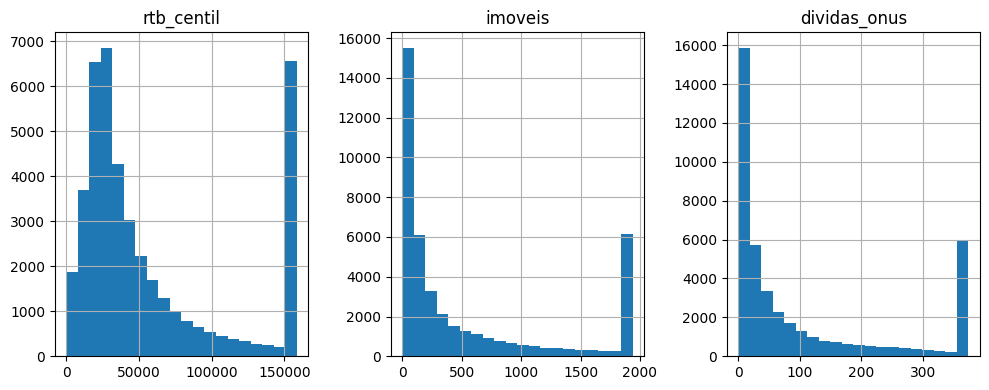

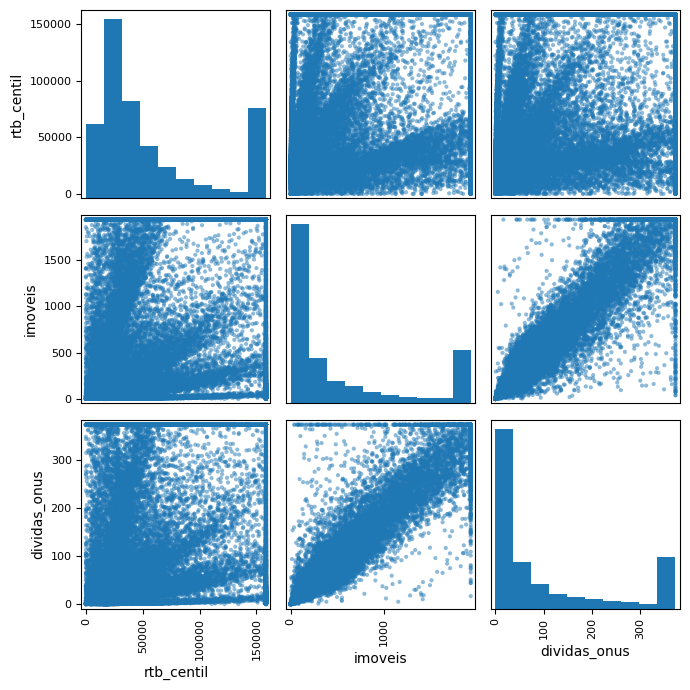

In [10]:
_ = df[["rtb_centil","imoveis","dividas_onus"]].hist(bins=20, figsize=(10,4), layout=(1,3))
plt.tight_layout()
plt.show()

_ = scatter_matrix(df[["rtb_centil","imoveis","dividas_onus"]], figsize=(7,7), diagonal='hist')
plt.tight_layout()
plt.show()


## Exportar dataset processado

Arquivo de saída: `data/processed/distribuicao-renda-3vars.csv`  
Junto com um `metadata.json` com informações de proveniência.


In [11]:
OUTPUT_CSV = DATA_PROCESSED / "distribuicao-renda-3vars.csv"
df.to_csv(OUTPUT_CSV, index=False)
print("Arquivo salvo em:", OUTPUT_CSV.resolve())

metadata = {
    "source_file": str(RAW_FILE),
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "encoding": used_encoding,
    "separator": used_sep,
    "columns_selected": ["rtb_centil","imoveis","dividas_onus"],
    "nulls_strategy": "drop rows with any nulls",
    "outliers_strategy": "winsorize via IQR (k=1.5)"
}
with open(DATA_PROCESSED / "distribuicao-renda-3vars.metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

metadata


Arquivo salvo em: C:\QuartoSemestre\kmeans-3d-cluster\data\processed\distribuicao-renda-3vars.csv


{'source_file': 'C:\\QuartoSemestre\\kmeans-3d-cluster\\data\\raw\\distribuicao-renda.csv',
 'generated_at': '2025-08-31T10:43:41',
 'encoding': 'utf-8',
 'separator': ';',
 'columns_selected': ['rtb_centil', 'imoveis', 'dividas_onus'],
 'nulls_strategy': 'drop rows with any nulls',
 'outliers_strategy': 'winsorize via IQR (k=1.5)'}

## (Opcional) Imputação de nulos por mediana

> Mantemos **como decisão padrão** a remoção de linhas com nulos nas 3 variáveis.
> Se a perda amostral for alta, podemos optar por **imputar por mediana** (por coluna).
> O código abaixo fica **comentado** como alternativa documentada.


In [12]:
# # Alternativa à remoção de nulos: imputação por mediana (USE SOMENTE SE JUSTIFICADO)
# for c in ["rtb_centil", "imoveis", "dividas_onus"]:
#     med = df[c].median()
#     df[c] = df[c].fillna(med)
# df.isna().sum()


## Sanidade pós-tratamentos

- Estatísticas descritivas finais
- Checagem rápida de correlações


In [13]:
display(df.describe())

corr = df[["rtb_centil", "imoveis", "dividas_onus"]].corr(method="pearson")
corr


,rtb_centil,imoveis,dividas_onus
count,42913.000000,42913.000000,42913.000000
mean,57834.639257,547.227608,104.212686
std,50378.005480,682.479764,130.840077
min,0.000000,0.040000,0.000000
25%,22200.000000,55.460000,9.580000
50%,36000.000000,189.470000,36.800000
75%,76697.380000,808.490000,155.240000
max,158443.450000,1938.035000,373.730000


,rtb_centil,imoveis,dividas_onus
rtb_centil,1.000000,0.235613,0.252543
imoveis,0.235613,1.000000,0.972000
dividas_onus,0.252543,0.972000,1.000000


## Visualizações rápidas

- Histogramas por variável
- *Scatter matrix* para relações bivariadas


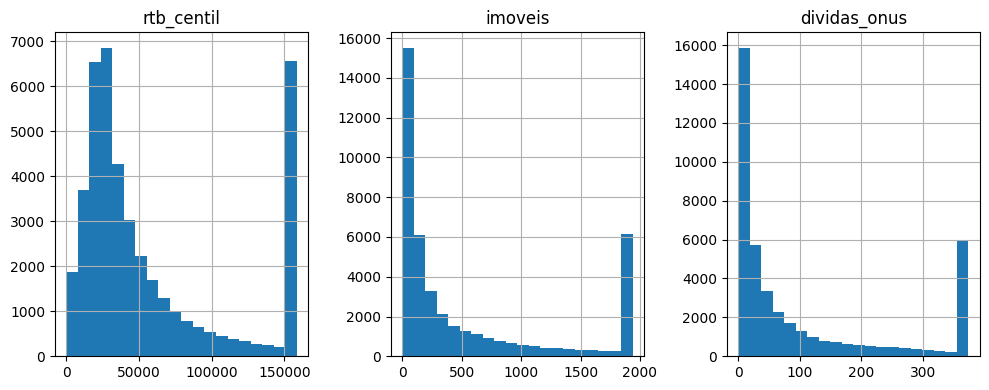

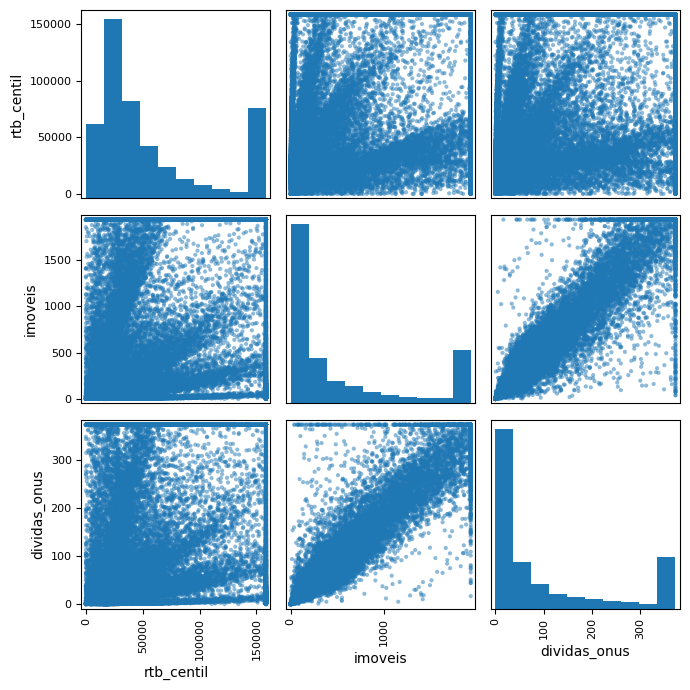

In [14]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

_ = df[["rtb_centil","imoveis","dividas_onus"]].hist(bins=20, figsize=(10,4), layout=(1,3))
plt.tight_layout()
plt.show()

_ = scatter_matrix(df[["rtb_centil","imoveis","dividas_onus"]], figsize=(7,7), diagonal='hist')
plt.tight_layout()
plt.show()


## Exportar dataset processado + metadados

- CSV final em `data/processed/distribuicao-renda-3vars.csv`
- `metadata.json` com informações de proveniência e decisões de limpeza


In [15]:
import json
from datetime import datetime
from pathlib import Path

ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

OUTPUT_CSV = DATA_PROCESSED / "distribuicao-renda-3vars.csv"
df.to_csv(OUTPUT_CSV, index=False)

metadata = {
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "source_file": str(RAW_FILE),
    "output_file": str(OUTPUT_CSV),
    "encoding": used_encoding,
    "separator": used_sep,
    "columns_selected": ["rtb_centil","imoveis","dividas_onus"],
    "nulls_strategy": "drop rows with any nulls (imputation by median kept as commented alternative)",
    "outliers_strategy": "winsorize via IQR (k=1.5)",
    "rows_final": int(len(df)),
}
with open(DATA_PROCESSED / "distribuicao-renda-3vars.metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("✔ CSV salvo em:", OUTPUT_CSV.resolve())
print("✔ Metadata salva em:", (DATA_PROCESSED / "distribuicao-renda-3vars.metadata.json").resolve())


✔ CSV salvo em: C:\QuartoSemestre\kmeans-3d-cluster\data\processed\distribuicao-renda-3vars.csv
✔ Metadata salva em: C:\QuartoSemestre\kmeans-3d-cluster\data\processed\distribuicao-renda-3vars.metadata.json


## Resumo do pipeline

- Arquivo bruto lido de `data/raw/`
- Seleção de 3 variáveis contínuas (RTB Centil, Imóveis, Dívidas/Ônus)
- Conversão para numérico
- Tratamento de nulos → remoção (opção alternativa: imputação por mediana)
- Tratamento de outliers → winsorização (IQR, k=1.5)
- Exportado dataset final: `data/processed/distribuicao-renda-3vars.csv`
- Exportado metadados: `data/processed/distribuicao-renda-3vars.metadata.json`

**Status:** pronto para revisão pelos colaboradores


## Próximos passos

- Registrar no README um resumo do pipeline (raw → processed).
- Migrar a **lógica consolidada** para `src/data_prep.py` (sem a parte exploratória).
- Iniciar a etapa de **modelagem** (normalização/padronização ocorrerá lá).
